# Titouan Christophe - 05129190
## VUB, MA2 CompSci SOFT

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
%matplotlib inline

As the simulations may take a significant amount of time, I implemented the games to run on the GPU using pyopencl. The code is distributed in the class `Runner`. As the code is rather low-level, it would take too much place in this report. You can however consult the code on [Github](https://github.com/titouanc/ld2-gpu).

A simulation Runner is instanciated with the simulations rules  (lattice type and payoffs), and compiles an OpenCL program. I obersved a ~100x speedup over my initial Python+numpy implementation, and it allows me to run a full simulation in less than 5 seconds, and therefore to explore different configurations very quickly.

In [2]:
from ld2 import Runner

r = Runner(moore=True, t=10, r=7, s=0, p=0)

We can then run the simulation on numerous worlds (a matrix of players) in parallel (each player of each world plays in parallel). We can specify the number of worlds, their size, as well as the number of iterations to run, and the initial probability of collaboration. We can also specify if we use the replicator update mechanism or the unconditional imitation.

![schema](runner_schema.png)

We first try the first proposed configuration in the assignment, and plot its final state, where collaborating players are represented by 1 and defecting players are represented by 0.

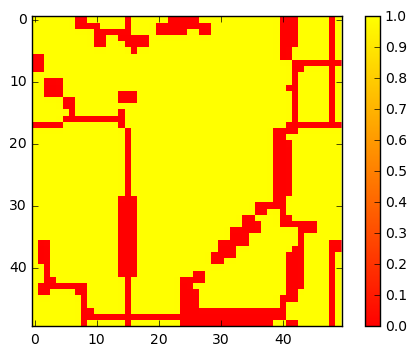

In [3]:
coop, players = r.run(n=50, worlds=1, iterations=50, p=0.5, replicator=False)
plt.imshow(players[0], interpolation='none', cmap=plt.cm.autumn)
plt.colorbar()
plt.show()

In the first run above, we can observe that a large portion of the players are cooperating.

For the following sections, we will need a function to plot a comparison of various runs with the same configuration (but each world has its own initial state).

In [4]:
 def plot_multiple_runs(coop_lvl, figsize=(10, 6), title=""):
    spec = GridSpec(1, 3, width_ratios=[10, 2, 1])

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(spec[0])
    
    X = np.arange(len(coop_lvl[0]))

    plt.plot(coop_lvl.T, alpha=0.1, c='k')
    
    ax.plot(X, coop_lvl.max(axis=0), marker='v', c='r', label='Max')
    ax.plot(X, coop_lvl.mean(axis=0), c='b', lw=2, label='Mean')
    ax.plot(X, coop_lvl.min(axis=0), marker='^', c='g', label='Min')
    
    ax.legend()
    ax.set_title("Cooperation levels over {} runs - {}".format(len(coop_lvl), title))
    ax.set_xlim(-1, X.max())
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cooperation level")

    ax = fig.add_subplot(spec[1], sharey=ax)
    ax.hist(coop_lvl[:,-1], bins=50, orientation='horizontal', range=(0, 1))
    ax.set_title("Distribution\n(last epoch)")
    ax.set_xlabel("Occurences")

    ax = fig.add_subplot(spec[2], sharey=ax)
    ax.boxplot(coop_lvl[:,-1])
    plt.show()

We now run the simulation on 150 worlds, and for 100 iterations:

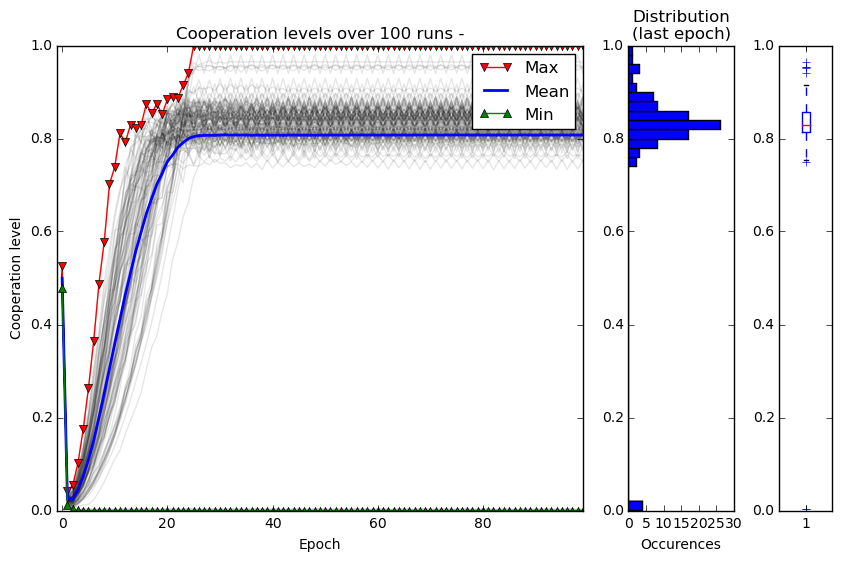

In [5]:
coop, players = r.run(n=50, worlds=100, iterations=100, p=0.5, replicator=False)
plot_multiple_runs(coop)

When observing the above graph, we can see that 4 worlds ended with all their players defecting, and all the others ended at a cooperation ratio of around 0.8 and higher. On some other simulation we even reached a cooperation level of 1 (everyone is cooperating).

We could see how a single world evolves:

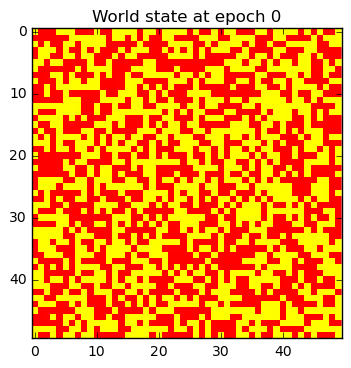

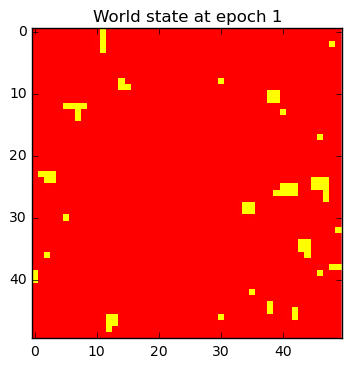

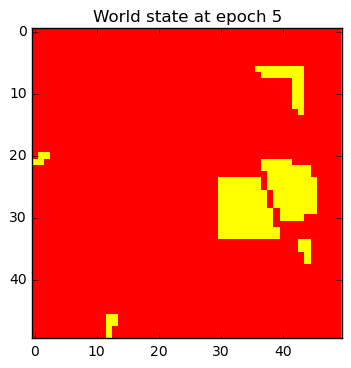

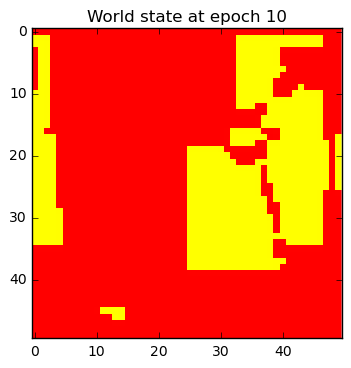

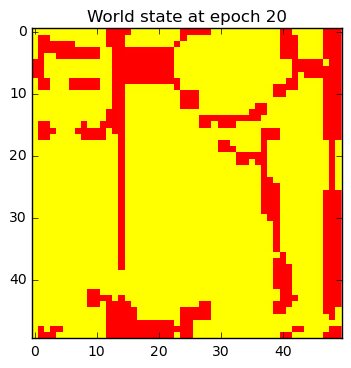

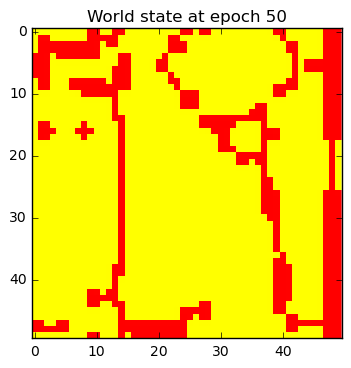

In [6]:
for t in [0, 1, 5, 10, 20, 50]:
    np.random.seed(42)
    coop, players = r.run(n=50, worlds=1, iterations=t, p=0.5, replicator=False)
    plt.imshow(players[0], interpolation='none', cmap=plt.cm.autumn)
    plt.title('World state at epoch {}'.format(t))
    plt.show()

According to the cooperation level graph, all players first defect, then gradually more and more players start to cooperate again, and the simulation is nearly stabilizated at 20 epochs, and this is what we see in the chronology above. We then compare the cooperation level for various grid sizes:

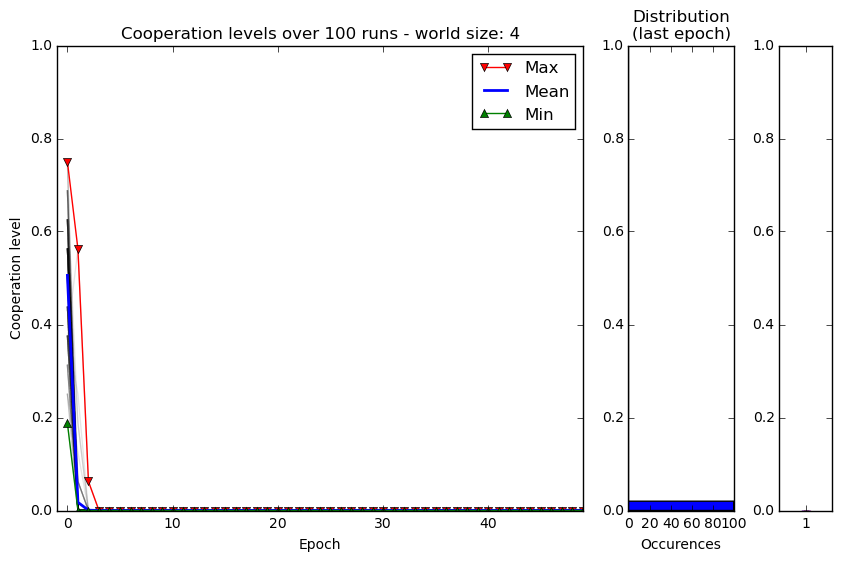

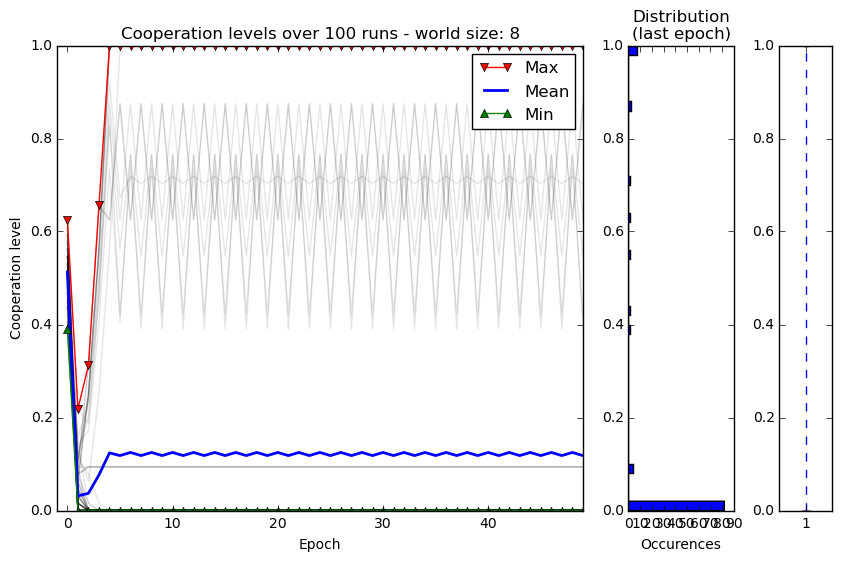

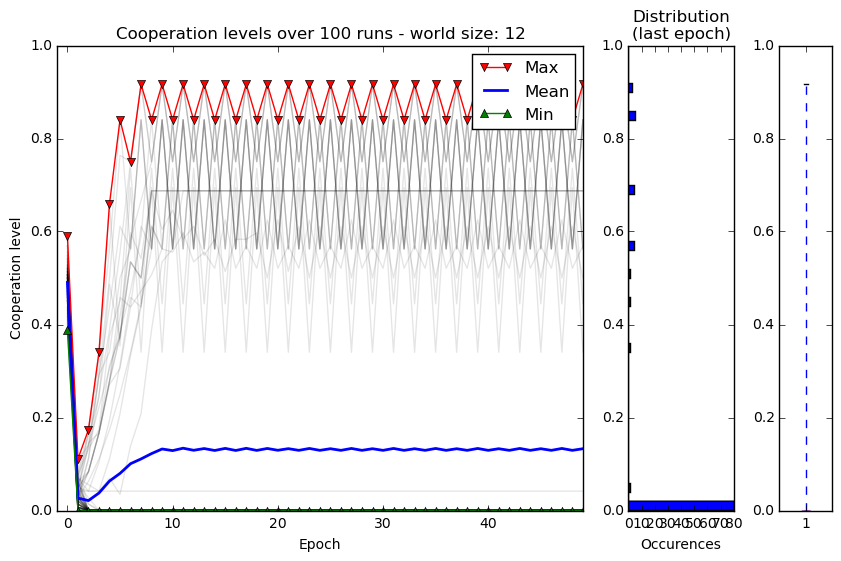

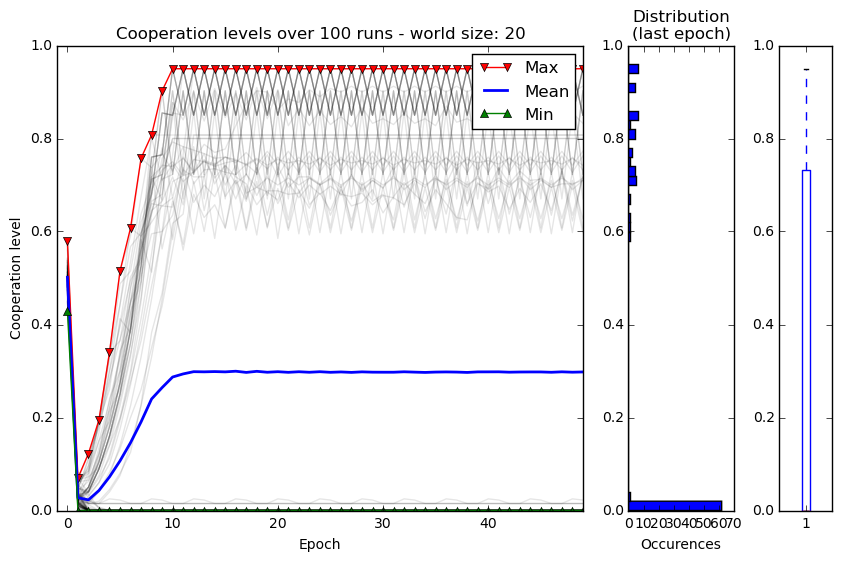

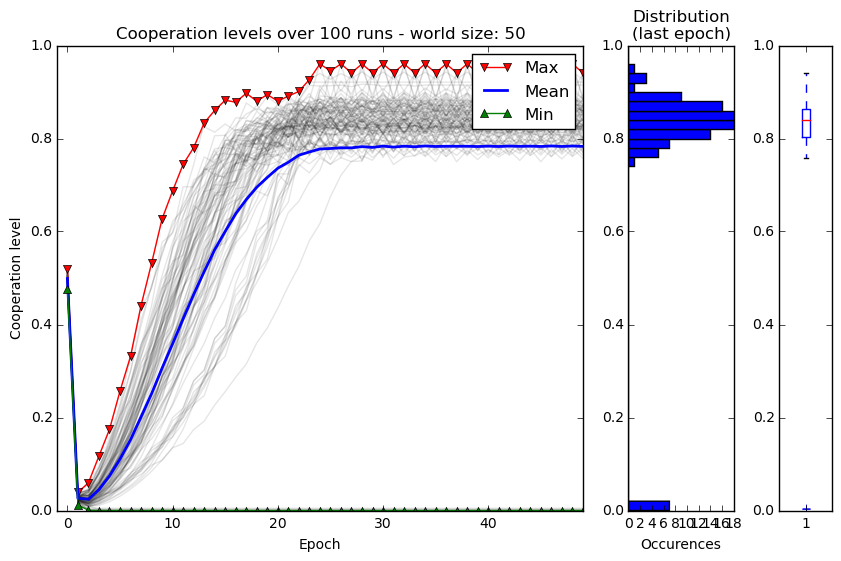

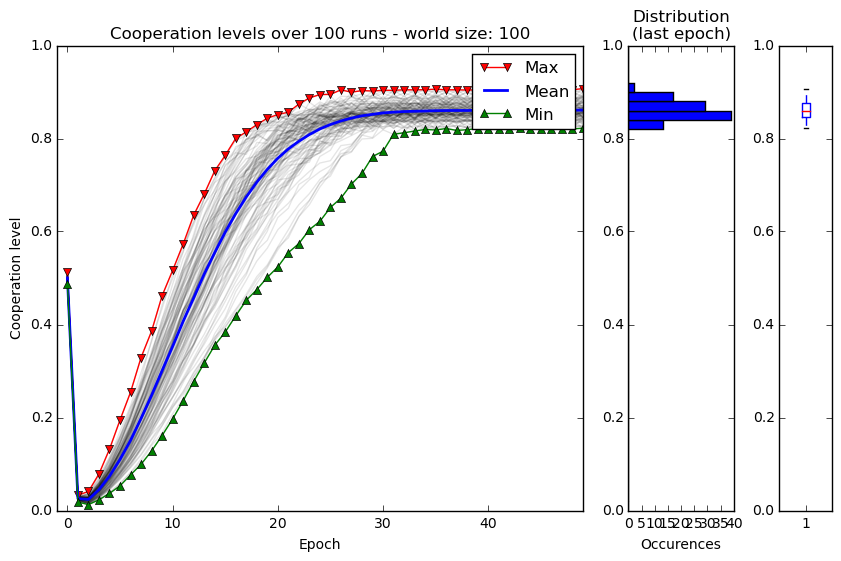

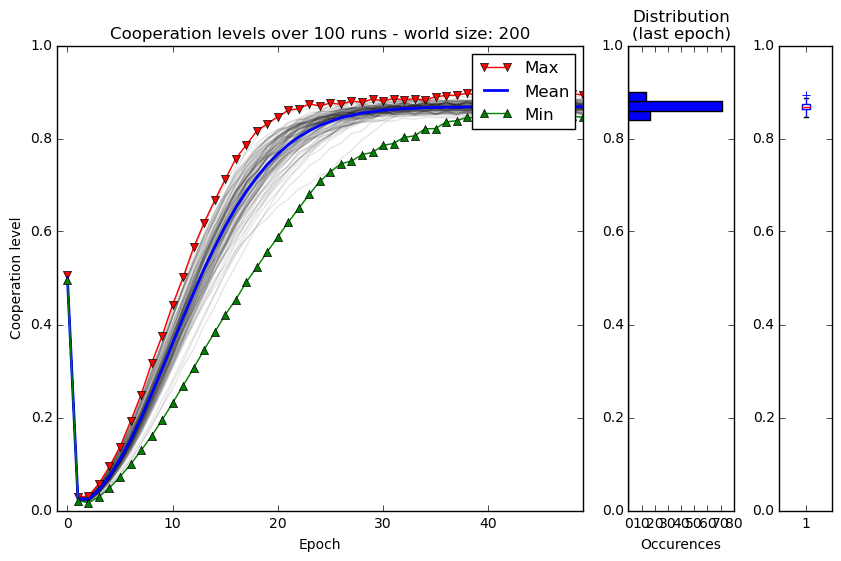

In [7]:
for n in [4, 8, 12, 20, 50, 100, 200]:
    coop, players = r.run(n=n, worlds=100, iterations=50, p=0.5, replicator=False)
    plot_multiple_runs(coop, title="world size: {}".format(n))
    plt.show()

From the above graphs, we see that the more the world is small, the more the players tend to defect. When the world is large enough, we can reach situation where more than half of the players are cooperating.

### Using a Von Neumann neighborhood

We then instantiate a new Runner where players only play with 4 neighbors, and observe their cooperation level.

In [17]:
r = Runner(moore=False, t=10, r=7, s=0, p=0)
coop, players = r.run(n=50, iterations=50, worlds=100, p=0.5, replicator=False)
plot_multiple_runs(coop)
plt.show()

IOError: [Errno 2] No such file or directory: 'ex1.cl'

## The snowdrift game, using the replicator rule

Using the replicator rule, unlike the previous simmulations, a player does not adopt the strategy of its best performing neighbor,  but rather choose one of them arbitrarily, and adopt its strategy with a probability proportional to the relative advantage of the neighbor. We use the following probability distribution:

$$ \frac{1 + \frac{W_j - W_i}{k \Delta_{MAX}(Payoffs)}}{2} $$

Where:

* $k$ is the number of players in the neighborhood
* $\Delta_{MAX}(Payoffs)$ is the difference between the highest payoff and the lowest payoff of the game
* $W_i$ and $W_j$ are the respective rewards of players $i$ and $j$

First, we need to prove that this is a probability distribution:

* It is clear to see that $\frac{W_j - W_i}{k \Delta_{MAX}(Payoffs)}$ is within $[-1, 1]$
* Then we normalize in $[0, 1]$ by adding 1 and dividing by 2.

It makes sense to update the players actions like that, because (taking the point of view of player $i$):

* If the other player has a much higher payoff than me, it makes sense to have a higher probability of switching to his strategy
* If our rewards are comparable, having half a chance to change my strategy is a good balance between exploration of new world states and exploitation of the actual benefit
* Otherwise, it is much more useful to keep my strategy

We first plot a cooperation level graph, to have an idea of the convergence of the game

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/pyopencl/cffi_cl.py:1469: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


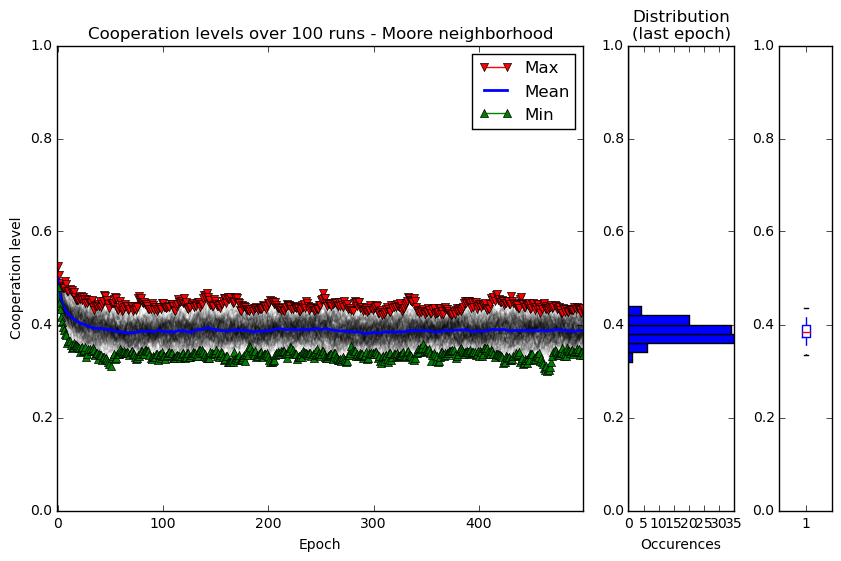

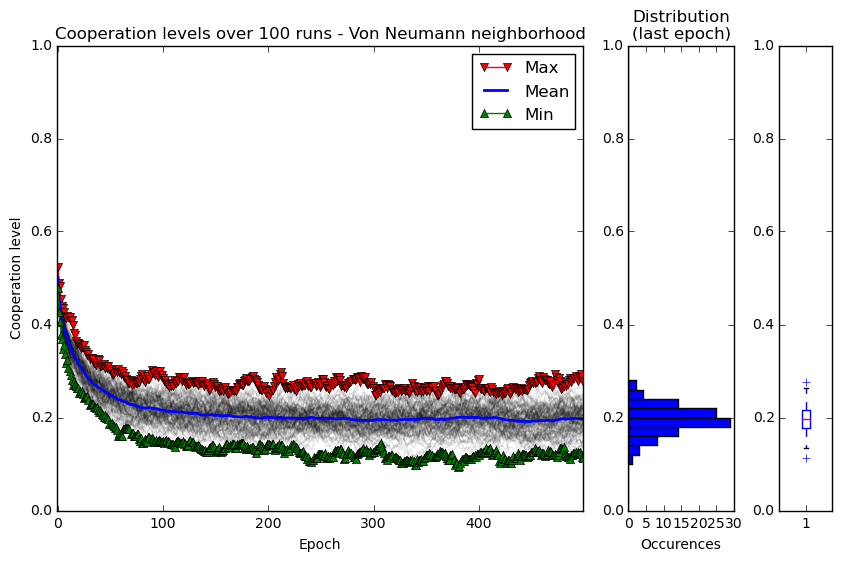

In [9]:
for moore, title in [(True, "Moore neighborhood"), (False, "Von Neumann neighborhood")]:
    r = Runner(moore=moore, t=10, r=7, s=3, p=0)
    coop, players = r.run(n=50, iterations=500, worlds=100, p=0.5, replicator=True)
    plot_multiple_runs(coop, title=title)
    plt.show()

The first thing we notice is that the variation rate of the cooperation level is rather slow. This is easily explained by the fact that only one neighbor is considered when switching strategies, so we only have a probability of $\frac{1}{k}$ to find the best performing neighbor, and maybe adopt its strategy (but if we select him, we are likely to switch). Secondly, we observe that the cooperation level is much lower than with the unconditional imitation rule, for the same reason.

As with the previous update rule, the Moore neighborhood allows for a higher final cooperation level than the Von Neumann neighborhood. For both the update rules, this can be explained by the fact that a cluster of cooperating players can grow faster and larger in a moore neighborhood, where a player also interact with diagonal players.

We then observe how the world state evolves over time:

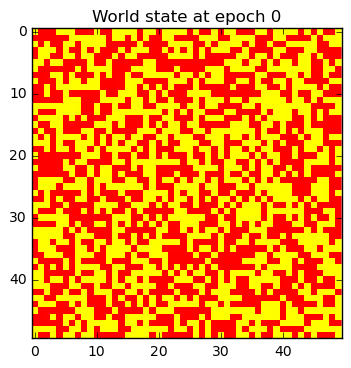

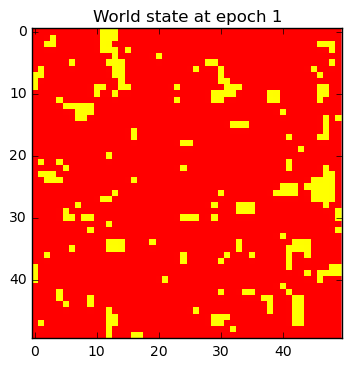

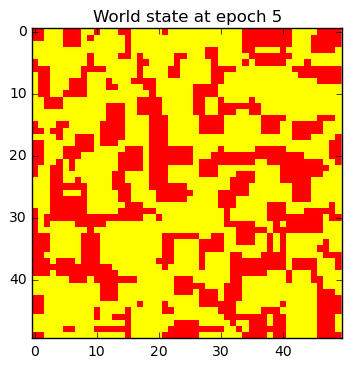

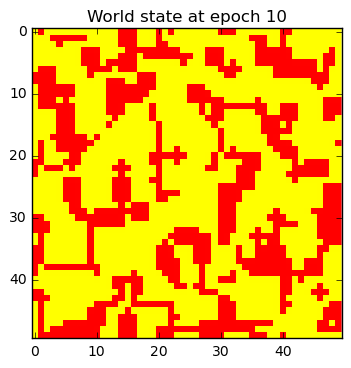

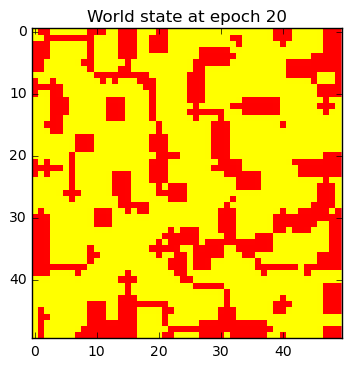

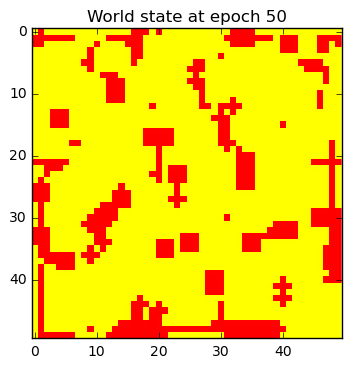

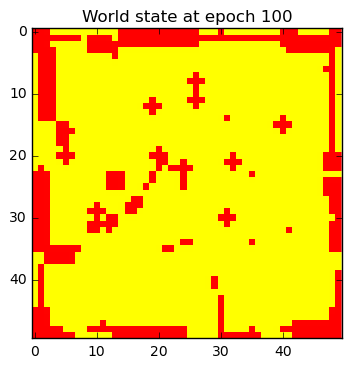

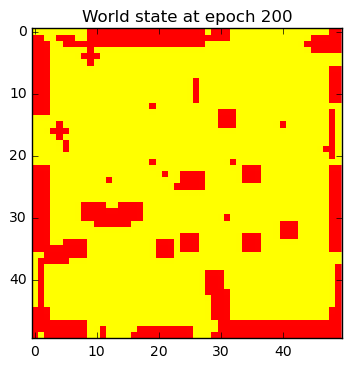

In [10]:
r = Runner(moore=True, t=10, r=7, s=3, p=0)
for t in [0, 1, 5, 10, 20, 50, 100, 200]:
    np.random.seed(42)
    coop, players = r.run(n=50, worlds=1, iterations=t, p=0.5, replicator=False)
    plt.imshow(players[0], interpolation='none', cmap=plt.cm.autumn)
    plt.title('World state at epoch {}'.format(t))
    plt.show()

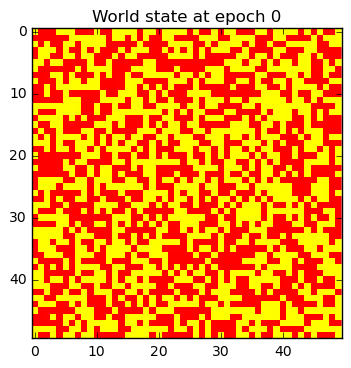

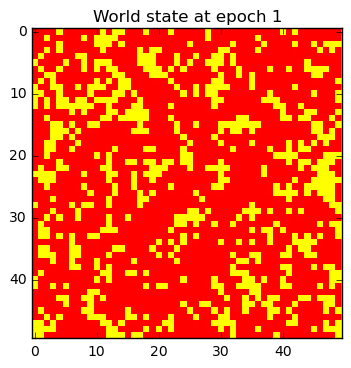

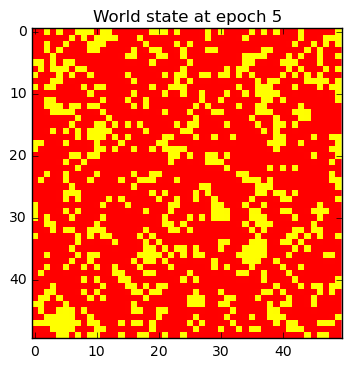

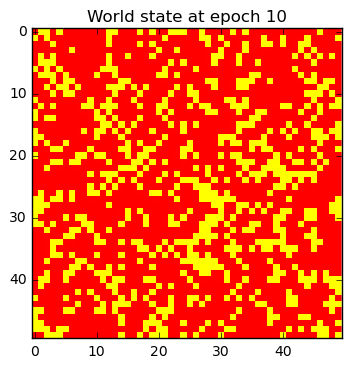

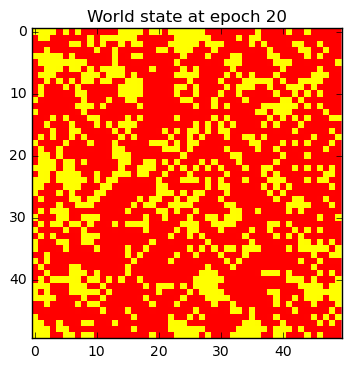

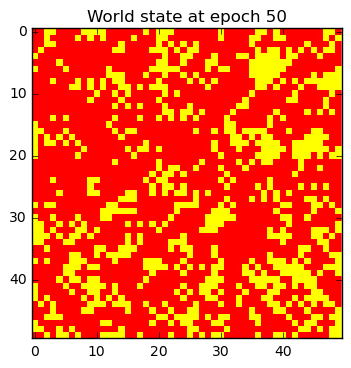

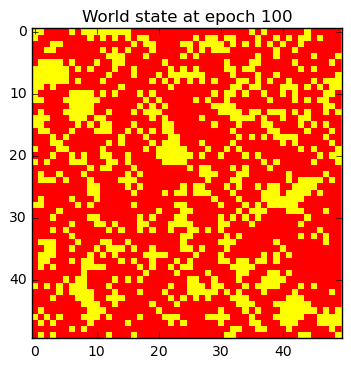

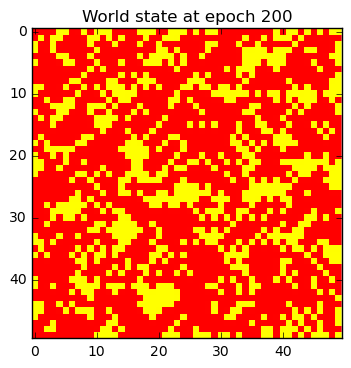

In [11]:
r = Runner(moore=False, t=10, r=7, s=3, p=0)
for t in [0, 1, 5, 10, 20, 50, 100, 200]:
    np.random.seed(42)
    coop, players = r.run(n=50, worlds=1, iterations=t, p=0.5, replicator=False)
    plt.imshow(players[0], interpolation='none', cmap=plt.cm.autumn)
    plt.title('World state at epoch {}'.format(t))
    plt.show()

From these 2 series of snapshots, we can see that big clusters of cooperating players are appearing in the Moore neighborhood, but they are not clear in Von Neumann, and are still fluctuating after 200 epochs.

### Influence of the initial state

Finally, we compare how the initial proportion of cooperating players influence the rest of the simulation, in both neighborhoods and both update rules. We plot the mean cooperation level over 100 runs for 21 initial cooperation level from 0 to 1. The color of the lines indicate the initial cooperation level (Red=0, Green=1).

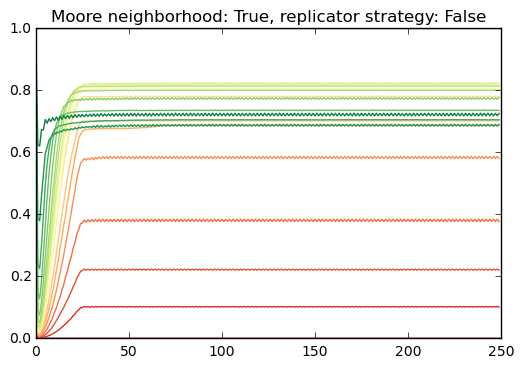

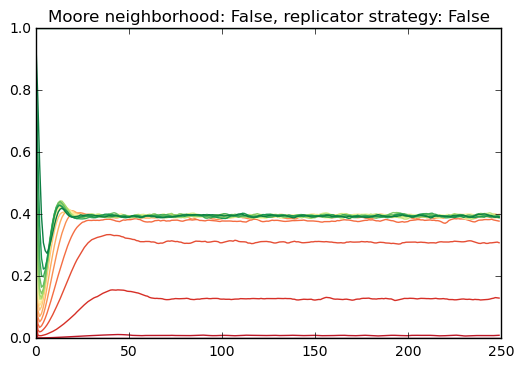

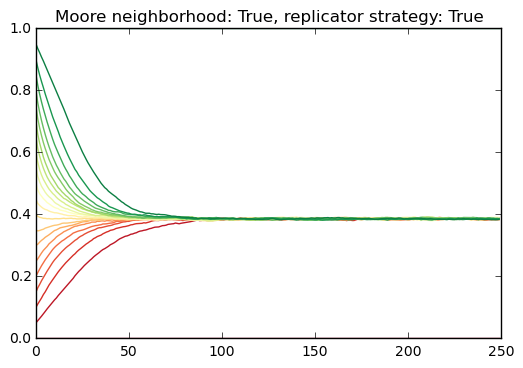

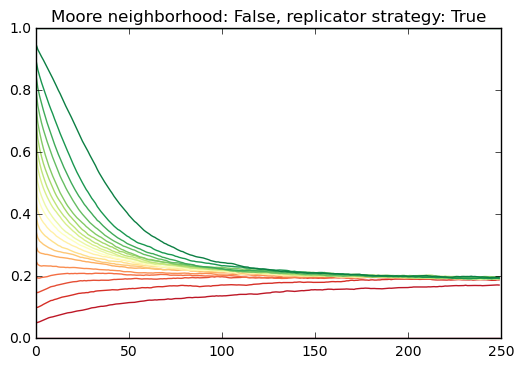

In [16]:
prob_levels = np.linspace(0, 1, 21)
colors = plt.cm.RdYlGn(prob_levels)
for replicator, s in [(False, 0), (True, 3)]:
    for moore in (True, False):
        plt.title("Moore neighborhood: {}, replicator strategy: {}".format(moore, replicator))
        r = Runner(moore=moore, t=10, r=7, s=s, p=0)
        for p, c in zip(prob_levels, colors):
            coop, _ = r.run(n=50, worlds=100, iterations=250, p=p, replicator=replicator)
            plt.plot(coop.mean(axis=0), c=c)
        plt.show()

We can notice a few interesting things on the above graphs:

* Using the unconditional imitation update rule, the final cooperation level depends on the initial cooperation level. We can explain this by the fact that in the first phase, nearly all players go to the defecting state. When this state is reached, clusters start to form and grow. However if the initial level of cooperator was low, clusters will have more difficulties to form as cooperators are far from each other, and other kind of stable structures, with more defectors will appear.
* Using the replicator strategy, the average cooperation level always tend to converge to the same value. This could be explained by the fact that the replicator rule is unlikely to provoke sudden changes in the world state